In [ ]:
!pip install opencv_python==3.4.2.17

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 25.0MB 9.0MB/s eta 0:00:012    |███████████▊                    | 9.1MB 13.5MB/s eta 0:00:02
  Found existing installation: opencv-python 4.1.1.26
    Uninstalling opencv-python-4.1.1.26:
      Successfully uninstalled opencv-python-4.1.1.26


In [ ]:
!pip install opencv_contrib_python==3.4.2.17

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 30.6MB 9.1MB/s eta 0:00:012


In [ ]:
import paddle
import cv2

print(paddle.__version__)
print(cv2.__version__)

2.0.1
3.4.2


In [ ]:
!ls

1787946.ipynb  image		__init__.py  PaddleDetection  process	   work
data	       image_stitch.py	output	     PaddlePaddle     __pycache__


In [1]:
from time import time
import os
import cv2
import sys

import numpy as np
import glob as glob
from matplotlib import pyplot as plt
import math
import datetime
# device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')

# print(torch.__version__)
print(cv2.__version__)
# print(torchvision.__version__)
# print(device)

# 该参数为阈值，不太清楚具体作用，但是测试中1.10效果比较好
GOOD_POINTS_LIMITED = 1

THR = 5


def get_save_image_name(output_dir, image_path):
    """
    Get save image name from source image path.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    image_name = os.path.split(image_path)[-1]
    name, ext = os.path.splitext(image_name)
    return os.path.join(output_dir, "{}".format(name)) + ext

# 图像拼接
class image_mosaic():
    # 初始化
    def __init__(self, fea_extraction,outpath):
        '''
        图像拼接类初始化
        :param fea_extraction: 特征点提取算法
        '''
        self.feature_extraction = fea_extraction
        self.outpath = outpath
        self.img_final = None
        self.img1 = None
        self.img2 = None
        self.stitch = None
        self.small_rate = 0.2

    # 图片大小调整
    def resize_image(self):

        h1, w1, p1 = self.img1.shape
        h2, w2, p2 = self.img2.shape

        h = max(h1, h2)
        w = max(w1, w2)
        self.img1 = cv2.copyMakeBorder(self.img1, int(np.ceil((h - h1) / 2)), int(np.floor((h - h1) / 2)),
                                       int(np.ceil((w - w1) / 2)), int(np.floor((w - w1) / 2)), cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))
        self.img2 = cv2.copyMakeBorder(self.img2, int(np.ceil((h - h2) / 2)), int(np.floor((h - h2) / 2)),
                                       int(np.ceil((w - w2) / 2)), int(np.floor((w - w2) / 2)), cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))

    # 图像拼接
    def mosaic(self, img1_path, img2_path):
        switch = {"ORB": self.creat_orb,
                  "SIFT": self.creat_sift,
                  "SURF": self.creat_surf,
                  "FLANN": self.creat_flann}
        self.stitch = switch.get(self.feature_extraction)()

        self.img1 = cv2.imread(img1_path)
        self.img2 = cv2.imread(img2_path)

        # print("图像拼接")
        h1, w1, p1 = self.img1.shape  # img1，新图像，w1、h1为宽和高
        h2, w2, p2 = self.img2.shape  # img2，待拼接图像，w2、h2为宽和高

        # M1 = np.array([[1., 0., w1], [0., 1., h1]])
        # dst1 = cv2.warpAffine(self.img1, M1, (w2 + 2 * w1, h2 + 2 * h1))  # 通过仿射变换将图像
        # dst2 = cv2.warpAffine(self.img2, M1, (w2 + 2 * w1, h2 + 2 * h1))  # 置于边长为w2+2*w1的中央

        start_fea = time()
        img1 = cv2.resize(self.img1,(int(w1*self.small_rate),int(h1*self.small_rate)))
        img2 = cv2.resize(self.img2,(int(w2*self.small_rate),int(h2*self.small_rate)))
        # img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        # img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        kp1, des1 = self.stitch.detectAndCompute(img1, None)  # self.stitch=cv2.xfeatures2d_SURF.
        kp2, des2 = self.stitch.detectAndCompute(img2, None)  # create(hessianThreshold=100)
        stop_fea = time()
        print("此次特征点提取需要" + str(stop_fea - start_fea) + "秒")

        start_fea = time()
        FLANN_INDEX_KDTREE = 0  # kd树
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)  # or pass empty dictionary
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1, des2, k=2)
        stop_fea = time()
        print("此次特征点匹配需要" + str(stop_fea - start_fea) + "秒")

        # 提取goodPoint
        goodPoints = []
        for m, n in matches:
            if m.distance < 0.6 * n.distance:
                goodPoints.append(m)

        # 画匹配图
        img3 = cv2.drawMatches(img1, kp1, img2, kp2, goodPoints, flags=2, outImg=None)
        plt.figure(5)
        plt.imshow(img3[:,:,::-1])
        cv2.imwrite(self.outpath+"/pair.jpg",img3)
        # cv2.imshow("asd",img3)

        src_pts = np.float32([kp1[m.queryIdx].pt for m in goodPoints]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in goodPoints]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        print("M:")
        print(M)
        
        # M_R = np.array([[1/self.small_rate, 0, 0], [0, 1/self.small_rate, 0], [0, 0, 1]])
        M_R = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1/self.small_rate]])
        M_L = np.array([[1, 0, 0], [0, 1, 0], [0, 0, self.small_rate]])
        M = np.dot(M_L, M)
        M = np.dot(M, M_R)
        M_T = np.array([[1., 0., w1], [0., 1., h1], [0, 0, 1]])

        imageTransform = cv2.warpPerspective(self.img1, np.dot(M_T,M), (w2+2*w1,h2+2*h1))
        img2 = cv2.warpPerspective(self.img2, M_T, (w2+2*w1,h2+2*h1)) 
        # a = int(w1*self.small_rate)
        # b = int(h1*self.small_rate)
        # Test = np.array([[1, 0, a], [0, 1, b], [0, 0, 1]])

        # imageTransform = cv2.warpPerspective(img1, M, (w2+2*w1,h2+2*h1))
        # img2 = cv2.warpPerspective(img2, M_R, (w2+2*w1,h2+2*h1)) 

        img1_save_name = get_save_image_name(self.outpath,img1_path)
        img2_save_name = get_save_image_name(self.outpath,img2_path)

        cv2.imwrite(img1_save_name, imageTransform)
        cv2.imwrite(img2_save_name, img2)
        cv2.imwrite(self.outpath+"/finall.jpg",np.maximum(img2, imageTransform))

        # plt.figure(1)
        # plt.imshow(self.img_final[:,:,::-1])

        plt.figure(1)
        plt.imshow(imageTransform[:,:,::-1])
        plt.figure(2)
        plt.imshow(img2[:,:,::-1])
        plt.figure(3)
        plt.imshow(np.maximum(img2, imageTransform)[:,:,::-1])

    # 图像拼接
    def creat_orb(self):
        print("creat_orb")
        return cv2.ORB_create()

    def creat_sift(self):
        print("creat_sift")
        return cv2.xfeatures2d.SIFT_create()

    def creat_flann(self):
        print("creat_flann")

    def creat_surf(self):
        print("creat_surf")
        return cv2.xfeatures2d_SURF.create(hessianThreshold=100)



3.4.2


In [2]:
image_tool = image_mosaic("SURF","./output")


In [4]:
img1_path = "./image/007.jpg"
img2_path = "./image/008.jpg"
image_tool.mosaic(img1_path, img2_path)

creat_surf
此次特征点提取需要0.8317356109619141秒
此次特征点匹配需要0.21161365509033203秒
M:
[[ 6.37730872e-01 -1.31625095e-02  2.36306349e+02]
 [-4.87003206e-02  8.78110566e-01  1.15904059e+01]
 [-4.53644427e-04  4.75976991e-05  1.00000000e+00]]


In [ ]:
!ls
!python PaddleDetection/tools/infer2label.py -c PaddleDetection/configs/ppyolo/ppyolo.yml  -o weights=https://paddlemodels.bj.bcebos.com/object_detection/ppyolo.pdparams --infer_dir=output

1787946.ipynb  image		__init__.py  PaddleDetection  process	   work
data	       image_stitch.py	output	     PaddlePaddle     __pycache__
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/setuptools/depends.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
2021-04-14 14:40:07,506 - INFO - Found 7 inference images in total.
2021-04-14 14:40:09,628 - INFO - Downloading ppyolo.pdparams from https://paddlemodels.bj.bcebos.com/object_detection/ppyolo.pdparams
100%|████████████████████████████████| 184084/184084 [00:10<00:00, 18314.11KB/s]
2021-04-14 14:40:20,721 - INFO - Not found annotation file annotations/instances_val2017.json, load coco17 categories.
2021-04-14 14:40:25,647 - INFO - Infer iter 0
2021-04-14 14:40:26,835 - INFO - Detection bbox results save in output/007.jpg
2021-04-14 14:40:28,157 - INFO - Detection bbox results save in output/007.json
2021-04-14 14:40:30,944 - 

In [ ]:
!ls

1787946.ipynb  image		__init__.py  PaddleDetection  process	   work
data	       image_stitch.py	output	     PaddlePaddle     __pycache__


In [ ]:
import json
import os
import logging
FORMAT = '%(asctime)s-%(levelname)s: %(message)s'
logging.basicConfig(level=logging.INFO, format=FORMAT)
logger = logging.getLogger(__name__)

label_path = "output/"

def get_label(infer_dir):
    images = set()
    infer_dir = os.path.abspath(infer_dir)
    assert os.path.isdir(infer_dir), \
        "infer_dir {} is not a directory".format(infer_dir)
    exts = ['json']
    for ext in exts:
        images.update(glob.glob('{}/*.{}'.format(infer_dir, ext)))
    images = list(images)

    assert len(images) > 0, "no image found in {}".format(infer_dir)
    logger.info("Found {} inference images in total.".format(len(images)))

    return images

json_list = get_label(label_path)
print(json_list)

2021-04-14 14:42:00,055 - INFO - Found 2 inference images in total.


['/home/aistudio/output/007.json', '/home/aistudio/output/008.json']


In [ ]:
json_label_list = []
for json_name in json_list:
    with open(json_name, 'r') as f:
        json_label_list.append(json.load(f))

print(json_label_list[0][0])

{'image_id': 0, 'category_id': 1, 'bbox': [6197.42236328125, 2243.9248046875, 460.15234375, 1310.927734375], 'score': 0.9662660956382751}


{'image_id': 0, 'category_id': 1, 'bbox': [6197.42236328125, 2243.9248046875, 460.15234375, 1310.927734375], 'score': 0.9662660956382751}
{'image_id': 6, 'category_id': 1, 'bbox': [6120.0830078125, 2252.818115234375, 519.658203125, 1367.03662109375], 'score': 0.9846720695495605}
output//finall_yolo0with0.jpg


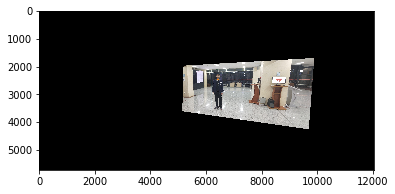

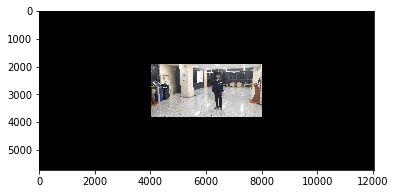

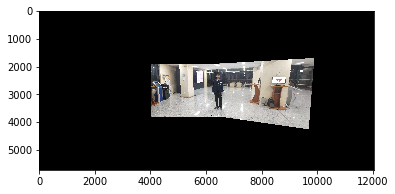

In [ ]:
def box_iou_xyxy(box1, box2):
    # 获取box1左上角和右下角的坐标

    x1min, y1min, x1max, y1max = box1[0], box1[1], box1[0]+box1[2] , box1[1]+box1[3]
    # 计算box1的面积
    s1 = box1[2]*box1[3]
    # 获取box2左上角和右下角的坐标
    x2min, y2min, x2max, y2max = box2[0], box2[1], box2[0]+box2[2], box2[1]+box2[3]
    # 计算box2的面积
    s2 = box2[2]*box2[3]
    
    # 计算相交矩形框的坐标
    xmin = np.maximum(x1min, x2min)
    ymin = np.maximum(y1min, y2min)
    xmax = np.minimum(x1max, x2max)
    ymax = np.minimum(y1max, y2max)
    # 计算相交矩形行的高度、宽度、面积
    inter_h = np.maximum(ymax - ymin + 1., 0.)
    inter_w = np.maximum(xmax - xmin + 1., 0.)
    intersection = inter_h * inter_w
    # 计算相并面积
    union = s1 + s2 - intersection
    # 计算交并比
    iou = intersection / union
    return iou

images_path = 'output/'

IOU_thera_L = 0.3
IOU_thera_U = 0.96

for i in range(len(json_label_list[0])):
    for j in range(len(json_label_list[1])):
        if json_label_list[0][i]["category_id"] == json_label_list[1][j]["category_id"]:
            if IOU_thera_L < box_iou_xyxy(json_label_list[0][i]['bbox'], json_label_list[1][j]['bbox']) < IOU_thera_U:
                print(json_label_list[0][i])
                print(json_label_list[1][j])
                image_i_path = os.path.join(images_path, json_list[0].split('/')[-1].split('.')[-2]+".jpg")
                img_i = cv2.imread(image_i_path)
                image_j_path = os.path.join(images_path, json_list[1].split('/')[-1].split('.')[-2]+".jpg")
                img_j = cv2.imread(image_j_path)

                box = json_label_list[1][j]['bbox']
                # xmin, ymin, xmax, ymax = box[0]-0.1*box[2], box[1]-0.1*box[3], box[0]+1.1*box[2] , box[1]+1.1*box[3]
                xmin, ymin, xmax, ymax = box[0]-0.1*box[2], box[1]-0.1*box[3], box[0]+1.1*box[2], box[1]+1.1*box[3]
                h, w, p = img_i.shape
                
                # xmin = max(0,xmin)
                # ymin = max(0,ymin)
                # xmax = min(xmax,h)
                # ymax = min(ymax,w)
                
                for a in range(int(ymin),int(ymax)):
                    for b in range(int(xmin),int(xmax)):
                        if np.sum(img_i[a][b]) > 0:
                            img_j[a][b] = img_i[a][b]

                cv2.imwrite(image_j_path,img_j)
                plt.figure(1)
                plt.imshow(img_i[:,:,::-1])
                cv2.imwrite(images_path+"/008"+str(i)+"with"+str(j)+".jpg",img_i)
                plt.figure(2)
                plt.imshow(img_j[:,:,::-1])
                cv2.imwrite(images_path+"/007"+str(i)+"with"+str(j)+".jpg", img_j)
                plt.figure(3)
                plt.imshow(np.maximum(img_i, img_j)[:,:,::-1])
                cv2.imwrite(images_path+"/finall_yolo"+str(i)+"with"+str(j)+".jpg",np.maximum(img_i, img_j))
                print(images_path+"/finall_yolo"+str(i)+"with"+str(j)+".jpg")



In [ ]:
!python PaddleDetection/tools/export_model.py -c PaddleDetection/configs/ppyolo/ppyolo.yml -o weights=https://paddlemodels.bj.bcebos.com/object_detection/ppyolo.pdparams
print("success!")

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/setuptools/depends.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
2021-04-12 16:24:55,150 - INFO - Not found annotation file annotations/instances_val2017.json, load coco17 categories.
2021-04-12 16:24:55,154 - INFO - Export inference config file to output/ppyolo/infer_cfg.yml
2021-04-12 16:24:55,363 - INFO - save_inference_model pruned unused feed variables im_id
2021-04-12 16:24:55,363 - INFO - Export inference model to output/ppyolo, input: ['image', 'im_size'], output: ['matrix_nms_0.tmp_0']...
